In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly
import re
import json

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)

# Данные

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.sample(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
354596,For sale,NaN,Condo,817 3rd Ave N UNIT 309,2,"{'atAGlanceFacts': [{'factValue': '2008', 'fac...",NaN,Nashville,"[{'rating': ['1/10', '2/10', '3/10'], 'data': ...","1,010",37201,2,TN,1.0,NaN,NaN,2096442,"$367,500"
305406,Active,NaN,Single Family Home,8426 Terrace Valley Circle,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Richmond,"[{'rating': ['8', '7', '5', '6', '9', '4', 'NR...","2,729",77407,4.0,TX,NaN,NaN,NaN,161733538,"$369,990"
55984,for sale,NaN,single-family home,6719 Brompton Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1940', 'fac...",yes,Houston,"[{'rating': ['6/10', '7/10', '10/10'], 'data':...","2,269 sqft",77005,3 Beds,TX,2.0,NaN,NaN,42218067,"$859,000"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
df.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


Как видим, у нас очень много мусора в данных: пропуски, строковые значения в численных столбцах и пр. Рассмотрим каждый столбец по отдельности и поймем что с ним делать.

# Посмотрим отдельно на каждую колонку

In [6]:
def show_col_info(colname):
    print(f'Колонка - {colname}')
    print('Кол-во пропусков:', df[colname].isna().sum())
    print('Кол-во уникальных значений:', df[colname].nunique())

## Колонка "target"

В первую очередь посмотрим на наш таргет сразу выбросим то, что нерелевантно.

Сразу удалим те записи, в которых у нас отсутвует target

In [7]:
df = df[df['target'].notna()]

Почистим сами значения

In [8]:
df['target'] = df['target'].str.replace('$', '')
df['target'] = df['target'].str.replace(',', '')
df['target'] = df['target'].str.replace('+', '')

In [9]:
def clear_target(x):
    try:
        return int(x)
    except:
        return 'DATA PROBLEM'

In [10]:
df['target_cleared'] = [clear_target(x) for x in df['target']]

In [11]:
df[df['target_cleared'] == 'DATA PROBLEM'][['target']].sample(5)

,target
187616,950/mo
249902,2300/mo
118278,1350/mo
109643,4795/mo
292918,2300/mo


Как видим, остались только "помесячные" - их мы удалим.

In [12]:
df = df[df['target_cleared'] != 'DATA PROBLEM']
df['target'] = df['target_cleared'] 
df = df.drop(columns='target_cleared')

In [13]:
df['target'] = df['target'].astype(int)

In [14]:
df[['target']].describe()

,target
count,3.743060e+05
mean,6.454072e+05
std,1.842196e+06
min,1.000000e+00
25%,1.877965e+05
50%,3.200000e+05
75%,5.845000e+05
max,1.950000e+08


Удалим некорректные значения (как например цена в $1).

Удалим все, что меньше 15 тысяч $

А также все, что больше 1м $

In [15]:
df = df[df['target'] > 15000]
df = df[df['target'] < 1000000]

In [16]:
df[['target']].describe()

,target
count,321710.000000
mean,342848.825635
std,223724.653446
min,15199.000000
25%,179900.000000
50%,292990.000000
75%,459900.000000
max,999999.000000


<AxesSubplot:>

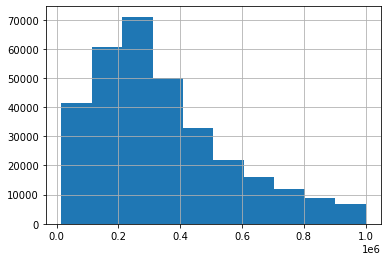

In [17]:
df['target'].hist()

Совсем другое дело!

## Колонка "status"

In [18]:
df['status'].value_counts()

for sale                  134151
Active                     88197
For sale                   37757
New construction            4625
foreclosure                 4568
                           ...  
Lease/Purchase                 1
Coming soon: Nov 11.           1
Coming soon: Dec 15.           1
Coming soon: Dec 12.           1
Under Contract W/ Bckp         1
Name: status, Length: 150, dtype: int64

In [19]:
df['status'] = df['status'].str.upper()

In [20]:
show_col_info('status')

Колонка - status
Кол-во пропусков: 34736
Кол-во уникальных значений: 143


In [21]:
df['status'].value_counts(dropna=False)[:20]

FOR SALE                     171910
ACTIVE                        88197
NaN                           34736
FORECLOSURE                    4877
NEW CONSTRUCTION               4625
PENDING                        4368
PRE-FORECLOSURE                1968
P                              1283
PRE-FORECLOSURE / AUCTION      1262
UNDER CONTRACT SHOW            1116
UNDER CONTRACT   SHOWING        743
 / AUCTION                      720
UNDER CONTRACT                  663
NEW                             594
CONTINGENT                      572
ACTIVE UNDER CONTRACT           514
PRICE CHANGE                    496
AUCTION                         481
A ACTIVE                        422
FORECLOSED                      283
Name: status, dtype: int64

In [22]:
def clear_status(s):
    try:
        if 'AUCTION' in s: 
            return 'AUCTION'
        elif 'COMIN' in s or 'DILIGE' in s: 
            return 'COMING'
        elif 'RENT' in s: 
            return 'RENT'
        elif 'LEASE' in s: 
            return 'RENT'
        elif 'PURCH' in s: 
            return 'RENT'
        elif 'PEND' in s: 
            return 'PENDING'
        elif 'FOREC' in s: 
            return 'FORECLOSURE'
        elif 'NEW' in s: 
            return 'NEW'
        elif 'CONTRACT' in s: 
            return 'CONTRACT'
        elif 'CONTINGE' in s: 
            return 'CONTINGENT'
        elif 'SOLD' in s or 'CLOSED' in s or 'ACCEPT' in s: 
            return 'SOLD'
        elif 'ACTIV' in s: 
            return 'ACTIVE'
        elif 'FOR SALE' in s: 
            return 'FOR SALE'
        elif 'BACKUP' in s: 
            return 'CONTRACT'
        elif 'BACK' in s or 'EXTEND' in s: 
            return 'ACTIVE'
        elif 'CONTINUE' in s: 
            return 'ACTIVE'
        elif s == 'C' or  s == 'CT': 
            return 'CONTRACT'
        elif s == 'P': 
            return 'PENDING'
        elif s == 'PS' or s == 'PF' or s == 'PI': 
            return 'PENDING'
        else: 
            return s
    except:
        return "NO_DATA"

In [23]:
df['status'] = [clear_status(x) for x in df['status']]

In [24]:
df['status'].value_counts()

FOR SALE        171910
ACTIVE           88858
NO_DATA          34736
FORECLOSURE       7130
PENDING           6215
NEW               5219
CONTRACT          3486
AUCTION           2501
CONTINGENT        1011
PRICE CHANGE       496
COMING             125
RENT                12
SOLD                11
Name: status, dtype: int64

## Колонки "private pool" и "PrivatePool"

In [25]:
show_col_info('private pool')
df['private pool'].value_counts(dropna=False)

Колонка - private pool
Кол-во пропусков: 318200
Кол-во уникальных значений: 1


NaN    318200
Yes      3510
Name: private pool, dtype: int64

In [26]:
show_col_info('PrivatePool')
df['PrivatePool'].value_counts(dropna=False)

Колонка - PrivatePool
Кол-во пропусков: 291329
Кол-во уникальных значений: 2


NaN    291329
yes     22243
Yes      8138
Name: PrivatePool, dtype: int64

In [27]:
df.loc[(df['private pool'] == 'Yes') | (df['PrivatePool'] == 'yes') | (df['PrivatePool'] == 'Yes'),
      ['private pool', 'PrivatePool']].sample(5)

,private pool,PrivatePool
122538,NaN,yes
155502,Yes,NaN
163307,NaN,yes
352788,NaN,yes
172975,NaN,yes


Как видим, колонки значат одно и то же, при этом значения не пересекаются.

Оставим один столбец `PrivatePool`, вставим недостающие "yes" из столбца `private pool`. Заменим все yes на 1, а пропуски на 0.

In [28]:
df.loc[df['private pool'] == 'Yes', 'PrivatePool'] = 'Yes'

In [29]:
df['PrivatePool'] = df['PrivatePool'].map({'Yes' : 1,
                                           'yes' : 1})
df['PrivatePool'] = df['PrivatePool'].fillna(0)

In [30]:
df = df.drop(columns='private pool')

In [31]:
df['PrivatePool'].value_counts()

0.0    287819
1.0     33891
Name: PrivatePool, dtype: int64

## Колонка "propertyType"

In [32]:
show_col_info('propertyType')
df['propertyType'].value_counts(dropna=False)

Колонка - propertyType
Кол-во пропусков: 26975
Кол-во уникальных значений: 1110


single-family home                80727
Single Family                     54556
Single Family Home                29119
NaN                               26975
condo                             21564
                                  ...  
Farmhouse, Historic Vintage           1
Traditional, Colonial, Federal        1
Georgian, Colonial                    1
Co-op, Traditional                    1
Old World, Ranch                      1
Name: propertyType, Length: 1111, dtype: int64

Как видим, здесь очень много уникальных значений, многие из которых очень похожи между собой.

In [33]:
df['propertyType'] = df['propertyType'].str.upper()

In [34]:
def parse_property_type(s):
    try:
        if 'SINGLE' in s or 'TRADITIONAL' in s: 
            return 'SINGLE'
        if 'FLAT' in s: 
            return 'FLAT'
        if 'TOWNH' in s or 'CONDO' in s or 'CLUSTER' in s: 
            return 'TOWNHOUSE'
        if 'COOP' in s or 'CO-OP' in s: 
            return 'COOP'
        if 'LAND' in s: 
            return 'LAND'
        if 'MULTI' in s: 
            return 'MULTI'
        if 'CONTEMPO' in s: 
            return 'CONTEMPORARY'
        if 'MOBI' in s or 'CARRI' in s: 
            return 'MOBILE'
        if 'TWO STOR' in s or '2 STOR' in s: 
            return 'TWO-STORY'
        if 'ONE STOR' in s or '1 STOR' in s: 
            return 'ONE-STORY'
        if 'STOR' in s in s: 
            return 'MULTY-STORY'
        if 'DETA' in s or 'DETA' in s: 
            return 'DETACHED'
        if 'RISE' in s or 'UNIT' in s or 'HIGH' in s: 
            return 'FLAT'
        if 'PENT' in s: 
            return 'PENTHOUSE'
        if 'RAN' in s: 
            return 'RANCH'
        if 'GARD' in s: 
            return 'GARDEN HOME'
        if 'CUST' in s or 'MANUF' in s or 'CRAFT' in s: 
            return 'CUSTOM'
        if 'ATTA' in s or 'PLEX' in s: 
            return 'ATTACHED'
        if 'FARM' in s: 
            return 'FARM'
        if 'LEVEL' in s: 
            return 'SPLIT-LEVEL'
        if 'OTHER' in s: 
            return 'OTHER'
        if 'COLO' in s: 
            return 'COLONIAL'
        if 'WARE' in s or 'COM' in s: 
            return 'COMMERCICAL'
        if 'COTT' in s or 'RESID' in s or 'COURT' in s: 
            return 'COTTAGE'
        if 'BOAT' in s: 
            return 'BOATHOUSE'
        if 'BUNGAL' in s:
            return 'BUNGALOW'
        if s == 'nan' or s == '': 
            return 'NO DATA'
        else:
            return 'OTHER'

    except:
         return 'NO DATA'

In [35]:
df['propertyType_parsed'] = [parse_property_type(x) for x in df['propertyType']]

In [36]:
df['propertyType_parsed'].value_counts()

SINGLE          174848
TOWNHOUSE        60954
NO DATA          26975
LAND             23983
MULTI             8661
ONE-STORY         3620
MOBILE            3394
COOP              3209
RANCH             3129
OTHER             3037
CONTEMPORARY      2984
TWO-STORY         1906
FLAT              1635
COLONIAL          1092
BUNGALOW           510
CUSTOM             390
GARDEN HOME        333
SPLIT-LEVEL        295
MULTY-STORY        205
COTTAGE            183
ATTACHED           125
DETACHED           108
FARM                73
PENTHOUSE           45
COMMERCICAL         13
BOATHOUSE            3
Name: propertyType_parsed, dtype: int64

In [37]:
df['propertyType'] = df['propertyType_parsed']
df = df.drop(columns='propertyType_parsed')

## Колонка "street"

In [38]:
show_col_info('street')
df['street'].value_counts(dropna=False)

Колонка - street
Кол-во пропусков: 1
Кол-во уникальных значений: 287376


Address Not Disclosed    605
Undisclosed Address      441
(undisclosed Address)    343
Address Not Available    162
Unknown Address           70
                        ... 
1511 Bridge St             1
3861 N Himalaya Rd #1      1
MLS #: DEGI3873635         1
19901 Naumann Rd           1
NaN                        1
Name: street, Length: 287377, dtype: int64

Огромное количество уникальных значений (это логично). Давайте вычленим из каждого адреса тип улицы (улица, бульвар и тп.)

In [39]:
def parse_street(s):
    s = str(s)
    if 'ADDRESS' in s: 
        return 'NO_ADDRESS'
    elif 'BLVD' in s or 'BOULEVARD' in s: 
        return 'BOULEVARD'
    elif 'WAY' in s: 
        return 'HWAY'
    elif 'CIR' in s: 
        return 'CIRCLE'
    elif 'CT' in s or 'COURT' in s: 
        return 'COURT'
    elif 'DR' in s or 'DRIVE' in s: 
        return 'DRIVE'
    elif 'RD' in s or 'ROAD' in s: 
        return 'ROAD'
    elif 'AVE' in s: 
        return 'AVENUE'
    elif 'ST' in s or 'STREET' in s: 
        return 'STREET'
    elif 'PL' in s: 
        return 'PLACE'
    elif 'LANE' in s: 
        return 'LANE'
    elif 'TR' in s or 'TRL' in s or 'TRAIL' in s: 
        return 'TRAIL'
    elif 'PARK' in s: 
        return 'PARK'
    else: 
        return 'OTHER'

In [40]:
df['street'] = df['street'].str.upper()

In [41]:
df['street'] = [parse_street(x) for x in df['street']]

In [42]:
df['street'].value_counts()

STREET        71449
DRIVE         57732
AVENUE        50348
ROAD          37169
OTHER         36661
COURT         18129
PLACE         13688
HWAY          11091
BOULEVARD     10986
CIRCLE         7966
TRAIL          3890
NO_ADDRESS     1627
PARK            650
LANE            324
Name: street, dtype: int64

Создадим признак наличия адреса

In [43]:
df['has_adress'] = 0
df.loc[df['street'] != 'NO_ADDRESS',
       'has_adress'] = 1

## Колонка "baths"

In [44]:
show_col_info('baths')
df['baths'].value_counts(dropna=False)

Колонка - baths
Кол-во пропусков: 87455
Кол-во уникальных значений: 154


NaN              87455
2 Baths          49313
3 Baths          31778
2                19790
2.0              15736
                 ...  
1 / 1 / 1 / 1        1
9.5                  1
1-0 / 1-0 / 1        1
3.2 Baths            1
19 Baths             1
Name: baths, Length: 155, dtype: int64

В Американской системе наличие ванной комнаты обозначается следующим образом: если 1 - это значит, что это полноценная ванная комната с душем, туалетом, ванной, раковиной и пр. Если 0.5 или 0.75 - значит чего-то не хватает. 

Давайте использовать просто кол-во ванных комнат без каких-либо придумок. Если данных нет, то будем 

In [45]:
def clear_baths(x):
    try:
        x = str(x)
        number = re.sub(r'[^0-9.,]', r'', x)
        number = float(number.replace(',', '.'))
        return np.ceil(number)
    except:
        if '-' in x or '~' in x:
            return 0.0
        else:
            return np.NaN

In [46]:
df['baths_cleared'] = [clear_baths(x) for x in df['baths']]

In [47]:
df[['propertyType', 'baths', 'baths_cleared']].sample(8)

,propertyType,baths,baths_cleared
370575,ONE-STORY,NaN,NaN
283290,NO DATA,NaN,NaN
160632,CONTEMPORARY,NaN,NaN
219459,SINGLE,1.5,2.0
322976,MULTI,2,2.0
140669,ONE-STORY,NaN,NaN
261015,SINGLE,2 Baths,2.0
287825,NO DATA,NaN,NaN


In [48]:
df['baths_cleared'].value_counts(dropna=False)

2.0        105193
NaN         87639
3.0         75698
4.0         25383
1.0         16830
5.0          5631
0.0          3159
6.0          1269
7.0           367
750.0         213
8.0           156
9.0            37
12.0           31
10.0           29
11.0           26
13.0           14
16.0            7
20.0            6
14.0            4
22.0            3
30.0            2
15.0            2
18.0            2
60.0            1
17.0            1
1111.0          1
28.0            1
25.0            1
19.0            1
241.0           1
10101.0         1
24.0            1
Name: baths_cleared, dtype: int64

Как видим, у нас все еще остались некоторые странные значения. Давайте посмотрим на них.

In [49]:
df.loc[(df['baths_cleared'] == 1111.0) | \
       (df['baths_cleared'] == 10101.0) | \
       (df['baths_cleared'] == 28.0) | \
       (df['baths_cleared'] == 241.0), 
       ['propertyType', 'baths', 'baths_cleared', 'target']]

,propertyType,baths,baths_cleared,target
11118,SINGLE,Bathrooms: 241,241.0,449000
24724,MULTI,1-0 / 1-0 / 1,10101.0,775000
110097,MULTI,1 / 1 / 1 / 1,1111.0,985000
332908,MULTI,28 Baths,28.0,175000


Давайте заменим все, что больше 99 квантиля - 99 квантилем.

In [50]:
df['baths_cleared'].quantile(0.99)

5.0

In [51]:
df.loc[df['baths_cleared'] > 5, 'baths_cleared'] = 5

In [52]:
df['baths_cleared'].value_counts(dropna=False)

2.0    105193
NaN     87639
3.0     75698
4.0     25383
1.0     16830
5.0      7808
0.0      3159
Name: baths_cleared, dtype: int64

Что делать с пропусками?

In [53]:
df.loc[df['baths_cleared'].isna(), 
       ['propertyType', 'baths', 'baths_cleared', 'target']].sample(7)

,propertyType,baths,baths_cleared,target
192287,NO DATA,NaN,NaN,189900
237600,ONE-STORY,NaN,NaN,205000
52715,SINGLE,NaN,NaN,219000
61625,NO DATA,NaN,NaN,359900
192542,COOP,NaN,NaN,165000
97170,NO DATA,NaN,NaN,98000
323918,TOWNHOUSE,NaN,NaN,99900


Точно - не понятно. Видим, что нет данных как в дорогих домах (в которых точно есть ванные), так и в дешевых.

In [54]:
df['baths_cleared'].mean()

2.5414596425870783

In [55]:
df['target'].mean()

342848.82563488855

Давайте сделаем так - если цена больше, чем средняя, то поставим кол-во ванных 3. Если меньше - то 2.

In [56]:
df.loc[(df['target'] > df['target'].mean()) & (df['baths_cleared'].isna()),
       'baths_cleared'] = 3

df.loc[(df['target'] < df['target'].mean()) & (df['baths_cleared'].isna()),
       'baths_cleared'] = 2

In [57]:
df['baths_cleared'].value_counts(dropna=False)

2.0    165486
3.0    103044
4.0     25383
1.0     16830
5.0      7808
0.0      3159
Name: baths_cleared, dtype: int64

Отлично. Идем дальше.

In [58]:
df['baths'] = df['baths_cleared']
df = df.drop(columns='baths_cleared')

## Колонка "homeFacts"

In [59]:
show_col_info('homeFacts')
df['homeFacts'].value_counts(dropna=False)[:5]

Колонка - homeFacts
Кол-во пропусков: 0
Кол-во уникальных значений: 277602


{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}               3912
{'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}    3079
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '', 'factLabel': 'lotsize'}

Переделаем из всех этих словарей новые колонки для каждого дома.

In [60]:
def clear_home_facts(x):
    x = x.replace("''", '0')
    x = x.replace("'", "")
    x = x.replace("None", '0')
    x = x.replace("No Data", '0')
    x = x.replace("No Info", '0')
    x = x.replace("/sqft", '')
    x = x.replace("$", '')
    return x

In [61]:
def parse_home_facts(s):
    try:
        res = []
        s = s.split("{'atAGlanceFacts': [{'factValue': ")[1]
        s = s.split(", 'factLabel': 'Year built'}, {'factValue': ")
        s[0] = clear_home_facts(s[0])
        res.append(s[0])
        
        s = s[1].split(", 'factLabel': 'Remodeled year'}, {'factValue': ")
        s[0] = clear_home_facts(s[0])
        res.append(s[0])
        
        s = s[1].split(", 'factLabel': 'Heating'}, {'factValue': ")
        res.append(s[0])
        
        s = s[1].split(", 'factLabel': 'Cooling'}, {'factValue': ")
        res.append(s[0])
        
        s = s[1].split(", 'factLabel': 'Parking'}, {'factValue': ")
        s[0] = clear_home_facts(s[0])
        res.append(s[0])
        
        s = s[1].split(", 'factLabel': 'lotsize'}, {'factValue': ")
        res.append(s[0])
        
        s = s[1].split(", 'factLabel': 'Price/sqft'}]}")
        s[0] = clear_home_facts(s[0])
        res.append(s[0])
        
        return int(res[0]), int(res[1]), res[2], res[3], res[4], res[5], res[6]
    
    except:
        return s

In [62]:
homeFacts = df['homeFacts'].map(parse_home_facts)

In [63]:
new_columns = ['hf_built_year', 'hf_remodeled_year' , 'hf_heating', 
               'hf_cooling', 'hf_parking', 'hf_lotsize' , 'hf_price_sqft' ]
hf_data = pd.DataFrame.from_records(homeFacts, columns = new_columns)

In [64]:
hf_data.sample(5)

,hf_built_year,hf_remodeled_year,hf_heating,hf_cooling,hf_parking,hf_lotsize,hf_price_sqft
130313,1947,0,'Electric','Central',2 spaces,None,86
313017,2016,0,'Electric','Central',Attached Garage,"'3,419 sqft lot'",181
198257,0,0,'','',0,'',131
80564,1938,1938,'Central Electric','Central Gas',0,"'5,327 Sq. Ft.'",472 / Sq. Ft.
265241,0,0,'','',0,'—',424 / Sq. Ft.


### Колонка "hf_built_year"

In [65]:
hf_data['hf_built_year'].value_counts(dropna=False)

0       49403
2019    28162
2006     7176
2005     6657
2007     6205
        ...  
1857        1
1829        1
1855        1
1845        1
1790        1
Name: hf_built_year, Length: 218, dtype: int64

In [66]:
hf_data[['hf_built_year']].describe()

,hf_built_year
count,3.217100e+05
mean,3.483014e+06
std,1.396249e+09
min,0.000000e+00
25%,1.935000e+03
50%,1.976000e+03
75%,2.005000e+03
max,5.599906e+11


In [67]:
hf_data['hf_built_year'].quantile(0.95)

2019.0

In [68]:
hf_data.loc[(hf_data.hf_built_year < 1800) | (hf_data.hf_built_year > 2015),
           'hf_built_year'].value_counts(dropna=False)

0               49403
2019            28162
2018             5399
2017             4317
2016             4195
2020             2087
2021               45
1799                3
1795                2
559990649990        2
2025                2
1057                1
1788                1
1019                1
1750                1
1208                1
1735                1
1796                1
1700                1
1                   1
1790                1
Name: hf_built_year, dtype: int64

In [69]:
hf_data.loc[(hf_data.hf_built_year < 1800), 'hf_built_year'] = 0

In [70]:
hf_data.loc[(hf_data.hf_built_year > 2015),
           'hf_built_year'].value_counts(dropna=False)

2019            28162
2018             5399
2017             4317
2016             4195
2020             2087
2021               45
2025                2
559990649990        2
Name: hf_built_year, dtype: int64

In [71]:
hf_data.hf_built_year.replace(559990649990, 0, inplace=True)
hf_data.hf_built_year.replace(2025, 2021, inplace=True)

In [72]:
df['built_year'] = list(hf_data['hf_built_year'])

Давайте заменим пропуски на медианное значение.

In [73]:
mean_built_year = df.loc[df['built_year'] != 0, 'built_year'].median()

In [74]:
df.loc[df['built_year'] == 0, 'built_year'] = mean_built_year

### Колонка "hf_remodeled_year"

In [75]:
hf_data['hf_remodeled_year'].value_counts(dropna=False)

0       191513
2006      4935
2005      4174
2007      3728
2008      3098
         ...  
1897         1
1862         1
1853         1
1846         1
1800         1
Name: hf_remodeled_year, Length: 146, dtype: int64

In [76]:
hf_data[['hf_remodeled_year']].describe()

,hf_remodeled_year
count,321710.000000
mean,802.550521
std,973.472384
min,0.000000
25%,0.000000
50%,0.000000
75%,1978.000000
max,2021.000000


Посмотрим на значения, где `hf_remodeled_year` был меньше, чем `hf_built_year` (такое физически не возможно)

In [77]:
hf_data[(hf_data['hf_built_year'] > hf_data['hf_remodeled_year']) & \
        (hf_data['hf_remodeled_year'] != 0)].sample(10)

,hf_built_year,hf_remodeled_year,hf_heating,hf_cooling,hf_parking,hf_lotsize,hf_price_sqft
86483,2005,2000,'No Data','No Data',0,'2 acres',0
99823,1940,1925,'Gas','',Attached Garage,'2500 sqft',375
242256,2017,2016,'Central Electric','Central Gas',0,'0.32 Acres',216 / Sq. Ft.
112984,2019,2018,'Forced Air','Central',Off Street,'3118 sqft',334
306785,2019,2013,'Other','Central',Attached Garage,'0.33 acres',133
262341,2011,1947,'Forced air','Central',0,'2.2 acres',0
239224,2007,1980,'Forced air','Central',2 spaces,"'6,751 sqft'",170
254629,2018,1961,'Heat pump','',0,"'7,135 sqft lot'",106
145124,1967,1925,'Forced Air','Central',Attached Garage,'0.53 acres',176
96255,2017,1957,'Other','Central',Attached Garage,"'9,152 sqft'",209


Поставим таким домам значение 0 - значит, что не ремоделировался

In [78]:
hf_data.loc[(hf_data['hf_built_year'] > hf_data['hf_remodeled_year']) & (hf_data['hf_remodeled_year'] != 0),
            'hf_remodeled_year'] = 0

Создадим фичу "было ремоделирование"

In [79]:
df['was_remodeled'] = list((hf_data['hf_remodeled_year'] == 0).map({True : 0,
                                                                     False : 1}))

In [80]:
df['remodel_year'] = list(hf_data['hf_remodeled_year'])

Создадим фичу "возраст дома"

In [81]:
df['house_age'] = 2022-df['built_year']

Также фича "лет с последней реконструкции"

Если не было реконструкции, то поставим -1

In [82]:
df['last_remodeled'] = 2021 - df['remodel_year']

df.loc[df['last_remodeled'] == 2021, 'last_remodeled'] = -1

### Колонка "hf_heating"

In [83]:
hf_data['hf_heating'].value_counts()

''                                                               84243
'Forced Air'                                                     72319
'Forced air'                                                     44728
'Other'                                                          25785
'Electric'                                                        8460
                                                                 ...  
', Electric Hot Air, Heat Pump - Heat, Natural Gas'                  1
'Baseboard, Heat pump, Other'                                        1
'Garage-Hybrid Electric Heat Pump'                                   1
'Baseboard, Gas Heater - Vented, Hot Water'                          1
'Alternative Heat Stove, Forced Air, Hot Air, Stove - Pellet'        1
Name: hf_heating, Length: 1752, dtype: int64

In [84]:
hf_data['hf_heating'].str.replace("'", "").str.lower().value_counts()[:20]

forced air                     117047
                                84243
other                           25785
electric                         8465
gas                              8358
heat pump                        8075
no data                          7118
central electric                 6739
central air                      6524
central                          5793
central, electric                4111
baseboard                        3422
none                             3141
electric heat                    3019
wall                             3002
heating system                   2406
forced air, heat pump            1536
natural gas heat                 1326
central air, ceiling fan(s)      1176
radiant                          1166
Name: hf_heating, dtype: int64

In [85]:
def clear_heat(s):
    if len(s) == 0 or s == '' or s =="''" or s == ' ' or 'NO DATA' in s: 
        return 'NO_DATA'
    if 'AIR' in s or 'HEAT PUMP' in s: 
        return 'AIR'
    if 'GAS' in s or 'PROPANE' in s: 
        return 'GAS'
    if 'ELECTRIC' in s: 
        return 'ELECTRIC'
    if 'NONE' in s or 'NO' in s: 
        return 'NONE'
    if 'CENTRAL' in s: 
        return 'CENTRAL'
    else: 
        return 'OTHER'

In [86]:
hf_data['hf_heating'] = hf_data['hf_heating'].str.replace("'", "").str.upper()

In [87]:
hf_data['hf_heating'] = [clear_heat(x) for x in hf_data['hf_heating']]

In [88]:
hf_data['hf_heating'].value_counts()

AIR         143709
NO_DATA      91361
OTHER        38850
ELECTRIC     23956
GAS          13408
CENTRAL       7183
NONE          3243
Name: hf_heating, dtype: int64

In [89]:
df['heating'] = list(hf_data['hf_heating'])

### Колонка "hf_cooling"

In [90]:
hf_data['hf_cooling'] = hf_data['hf_cooling'].str.replace("'", "").str.upper()

In [91]:
hf_data['hf_cooling'].value_counts()[:20]

CENTRAL                                            137723
                                                    96673
CENTRAL AIR                                         13715
NONE                                                 9713
NO DATA                                              8965
HAS COOLING                                          8095
CENTRAL ELECTRIC                                     5931
WALL                                                 3644
CENTRAL GAS                                          3317
CENTRAL HEATING                                      2738
COOLING SYSTEM                                       2399
OTHER                                                1537
CENTRAL A/C (ELECTRIC), CENTRAL HEAT (GAS)           1509
CENTRAL A/C                                          1428
CENTRAL A/C (ELECTRIC), CENTRAL HEAT (ELECTRIC)      1382
CENTRAL, ELECTRIC                                    1053
REFRIGERATION                                        1044
EVAPORATIVE   

In [92]:
def clear_cooling(s):
    if len(s) == 0 or s == '' or s =="''" or s == ' ' or 'NO DATA' in s: 
        return 'NO_DATA'
    if 'CENTRAL' in s: 
        return 'CENTRAL'
    if 'NONE' in s or 'NO' in s: 
        return 'NONE'
    else: 
        return 'OTHER'

In [93]:
hf_data['hf_cooling'] = [clear_cooling(x) for x in hf_data['hf_cooling']]

In [94]:
hf_data['hf_cooling'].value_counts()

CENTRAL    179467
NO_DATA    105638
OTHER       26654
NONE         9951
Name: hf_cooling, dtype: int64

In [95]:
df['cooling'] = list(hf_data['hf_cooling'])

### Колонка "hf_parking"

In [96]:
hf_data['hf_parking'].value_counts()[:20]

0                                   161697
Attached Garage                      60149
2 spaces                             25275
1 space                              13153
Detached Garage                      11623
Carport                               7156
3 spaces                              3677
Off Street                            3181
Carport, Attached Garage              2633
1                                     2627
2                                     2321
4 spaces                              2136
Off street                            1410
On Street                             1075
Attached Garage, Detached Garage      1029
Attached Garage, Carport               863
Parking Desc                           776
Driveway                               668
Detached Garage, Attached Garage       562
6 spaces                               485
Name: hf_parking, dtype: int64

In [97]:
def clear_parking(s):
    if '1' in s or "ONE" in s or 'SING' in s: 
        return 'ONE'
    elif '2' in s or "TWO" in s or "DOUB" in s: 
        return 'TWO'
    elif '3' in s: 
        return 'THREE'
    elif 'ATTACHED' in s: 
        return 'ATTACHED'
    elif 'DETACHED' in s: 
        return 'DETACHED'
    elif 'OFF' in s: 
        return 'OFF_STREET'
    elif 'ON' in s: 
        return 'ON_STREET'
    elif 'CAR' in s: 
        return 'CARPORT'
    elif '4' in s or '5' in s or '6' in s or '7' in s or '8' in s or '9' in s: 
        return 'FOUR_OR_MORE'
    elif 'NONE' in s or 'NO' in s or s == '0': 
        return 'NONE'
    else: 
        return 'OTHER'

In [98]:
hf_data['hf_parking'] = [clear_parking(x) for x in hf_data['hf_parking']]

In [99]:
hf_data['hf_parking'].value_counts()

NONE            161697
OTHER           103803
TWO              30134
ONE              16684
THREE             4385
FOUR_OR_MORE      4192
ON_STREET          815
Name: hf_parking, dtype: int64

In [100]:
df['parking'] = list(hf_data['hf_parking'])

### Колонка "hf_lotsize"

У нас уже есть колонка с данными о площади, но вдруг это какая-то другая площадь. Давайте ее тоже возьмем.

In [101]:
hf_data['hf_lotsize'].value_counts(dropna=False)[:20]

''               27827
None             24849
'—'              19965
'No Data'         4973
'-- sqft lot'     3543
'0.26 acres'      2069
'0.28 acres'      1777
'0.25 acres'      1772
'0.27 acres'      1696
'0.29 acres'      1557
'6,098 sqft'      1435
'0.34 acres'      1343
'7,405 sqft'      1291
'6,534 sqft'      1232
'0.3 acres'       1210
'0.31 acres'      1122
'10,000 sqft'     1108
'5,227 sqft'      1048
'0.32 acres'      1044
'4,356 sqft'      1012
Name: hf_lotsize, dtype: int64

Все таки этот столбец будет очень проблемотичен, тк есть данные в квадратных футах, есть в акрах, есть пропуски. К тому же, он будет сильно коррелировать со столбцом sqft в основном датасете.

### Колонка "hf_price_sqft"

In [102]:
hf_data['hf_price_sqft'].value_counts(dropna=False)

0                   49235
122                  1436
121                  1436
123                  1433
127                  1427
                    ...  
1,210                   1
129900 / Sq. Ft.        1
1,766                   1
640 / Sq. Ft.           1
1343 / Sq. Ft.          1
Name: hf_price_sqft, Length: 2463, dtype: int64

In [103]:
hf_data['hf_price_sqft'] = [re.sub(r'[^0-9.,]', r'', x).replace('..', '.') for x in hf_data['hf_price_sqft']]

In [104]:
hf_data['hf_price_sqft'] = hf_data['hf_price_sqft'].str.replace(',', '.').astype(float)

In [105]:
hf_data['hf_price_sqft'].value_counts(dropna=False)

0.000       49235
125.000      1713
121.000      1707
128.000      1702
123.000      1696
            ...  
1181.000        1
1.466           1
1.181           1
185.900         1
2.143           1
Name: hf_price_sqft, Length: 1515, dtype: int64

Если честно, мне кажется, что этот столбец неправильно использовать, тк цена дома очень сильно зависит от цены на квадратный фут. Давайте лучше не будем его использовать.

In [106]:
df = df.drop(columns='homeFacts')

## Колонка "fireplace"

In [107]:
df.sample(3)

,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,has_adress,built_year,was_remodeled,remodel_year,house_age,last_remodeled,heating,cooling,parking
226121,FOR SALE,TOWNHOUSE,DRIVE,2.0,NaN,Weston,"[{'rating': ['8/10', '9/10', '9/10'], 'data': ...","1,268 sqft",33326,3 Beds,FL,NaN,NaN,0.0,A10726022,259900,1,1984,1,1985,38,36,AIR,CENTRAL,NONE
222611,NO_DATA,SINGLE,OTHER,3.0,NaN,San Antonio,"[{'rating': ['NA', 'NA', '7/10'], 'data': {'Di...","2,614",78245,4,TX,2.0,NaN,0.0,NaN,319990,1,1985,0,0,37,-1,NO_DATA,NO_DATA,TWO
368375,FOR SALE,TOWNHOUSE,CIRCLE,2.0,NaN,Lauderhill,"[{'rating': ['3/10', '3/10', '4/10'], 'data': ...","1,390 sqft",33319,2 Beds,FL,4.0,NaN,0.0,F10126203,115000,1,1973,1,1974,49,47,OTHER,NO_DATA,NONE


In [108]:
df['fireplace'].value_counts(dropna=False)[:15]

NaN               235755
yes                41448
Yes                17025
1                  13291
Not Applicable      1981
2                   1601
Fireplace            683
Living Room          380
Wood Burning         291
Fireplace YN         282
1 Fireplace          273
No                   270
0                    261
Gas/Gas Logs         258
FAMILYRM             239
Name: fireplace, dtype: int64

Очень много лишних значений. Давайте будем считать, что каминов можем быть 0, 1 или 2.

In [109]:
df['fireplace'] = df['fireplace'].str.lower()

In [110]:
df['fireplace'].value_counts(dropna=False)[:15]

NaN                 235755
yes                  58473
1                    13291
not applicable        1981
2                     1601
fireplace              683
living room            380
wood burning           291
fireplace yn           282
1 fireplace            273
no                     270
0                      261
gas/gas logs           258
familyrm               239
special features       234
Name: fireplace, dtype: int64

In [111]:
def clear_fire(s):
    try:
        s = str(s)
        if s == 'nan':
            return 0
        if 'yes' in s or '1' in s or 'wood' in s or 'living' in s or 'gas' in s \
                      or 'one' in s or 'electric' in s or 'fireplace' in s or 'family' in s:
            return 1
        if '2' in s:
            return 2
        if 'no' in s or 'storage' in s or 'n/k' in s or 'decorative' in s:
            return 0
        else:
            return 1
    except:
        return 0

In [112]:
df['fireplace'].apply(lambda x: clear_fire(x)).value_counts(dropna=False)[:25]

0    238621
1     81485
2      1604
Name: fireplace, dtype: int64

In [113]:
df['fireplace'] = df['fireplace'].apply(lambda x: clear_fire(x))

## Колонка "city"

In [114]:
show_col_info('city')
df['city'].str.upper().value_counts(dropna=False)

Колонка - city
Кол-во пропусков: 19
Кол-во уникальных значений: 1924


HOUSTON         22026
SAN ANTONIO     15127
MIAMI           13138
JACKSONVILLE     9506
DALLAS           7503
                ...  
TUCKAHOE            1
VININGS             1
SUWANNEE            1
NOBLESVILLE         1
WILLIAMSPORT        1
Name: city, Length: 1818, dtype: int64

Всего 19 пропусков. Их можно удалить.

In [115]:
df = df.dropna(subset=['city'])

In [116]:
df['city'] = df['city'].str.upper()

## Колонка "schools"

In [117]:
def clear_school(s):
    s = s[1:-1]
    s = s.replace("'", '"')
    s = s.split(', "name"')
    s = s[0] + "}"
    s = s.replace(' None, ', ' "None", ')

    d = json.loads(s)
    dictance = []
    grades = []
    rating = []
    grades = d['data']['Grades']
    for i in d['data']['Distance']:
        i = float(i.replace('mi', ''))
        dictance.append(i)
    for i in d['rating']:
        if '/'in i:
            i = i.split('/')[0]
        rating.append(i)

    return dictance, grades, rating

In [118]:
schools = df['schools'].map(clear_school)

In [119]:
school_data = pd.DataFrame.from_records(schools, columns = ['sk_dist', 'sk_grades', 'sk_rating'])

In [120]:
school_data

,sk_dist,sk_grades,sk_rating
0,"[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[4, 4, 7, NR, 4, 7, NR, NR]"
1,"[1.65, 1.32, 1.01]","[9-12, 3-8, PK-8]","[4, None, 4]"
2,[],[],[]
3,"[0.8, 8.3, 4.2, 2.0]","[Preschool to 4, Preschool to 12, 5 to 8, 1 to...","[3, 3, 1, NR]"
4,"[0.7, 0.4, 2.2]","[Preschool to 5, 6 to 8, 9 to 12]","[4, 2, 2]"
...,...,...,...
321686,"[0.4, 0.1]","[PK-5, 6-12]","[3, 3]"
321687,"[10.61, 1.42, 0.4]","[9-12, 9-12, PK-8]","[1, 5, 7]"
321688,"[0.48, 0.73]","[PK-5, 6-8]","[5, 4]"
321689,"[1.3, 0.5, 1.9]","[PK-5, 6-8, 9-12]","[NA, NA, NA]"


Добавим количество школ

In [121]:
school_data['n_schools'] = school_data['sk_dist'].apply(lambda x: len(x))

Добавим минимальную и среднюю дистацию до школ

In [122]:
def min_dist(x):
    try:
        return np.min(x)
    except:
        return 'NoData'
    
def mean_dist(x):
    try:
        return np.mean(x)
    except:
        return 'NoData'

In [123]:
school_data['min_dist'] = school_data['sk_dist'].apply(lambda x: min_dist(x))
school_data['mean_dist'] = school_data['sk_dist'].apply(lambda x: mean_dist(x))

Для тех записей, где нет школ, поставим значение 99

In [124]:
school_data.loc[school_data['n_schools'] == 0, 'min_dist'] = 99
school_data.loc[school_data['n_schools'] == 0, 'mean_dist'] = 99

Найдем минимальный, средний и максимальный рейтинг школ

In [125]:
def min_rating(x):
    try:
        rating = []
        for r in x:
            if r.isdigit():
                rating.append(int(r))
        return np.min(rating)
    except:
        return 'NoData'
    
def max_rating(x):
    try:
        rating = []
        for r in x:
            if r.isdigit():
                rating.append(int(r)) 
        return np.max(rating)
    except:
        return 'NoData'
    
def mean_rating(x):
    try:
        rating = []
        for r in x:
            if r.isdigit():
                rating.append(int(r))
        return np.mean(rating)
    except:
        return 'NoData'

In [126]:
school_data['min_rating'] = [min_rating(x) for x in school_data['sk_rating']]
school_data['max_rating'] = [max_rating(x) for x in school_data['sk_rating']]
school_data['mean_rating'] = [mean_rating(x) for x in school_data['sk_rating']]

In [127]:
school_data.loc[school_data['min_rating'] == 'NoData', 'min_rating'] = school_data['mean_rating'].mean()
school_data.loc[school_data['max_rating'] == 'NoData', 'max_rating'] = school_data['mean_rating'].mean()
school_data.loc[school_data['mean_rating'].isna(), 'mean_rating'] = school_data['mean_rating'].mean()

In [128]:
school_data

,sk_dist,sk_grades,sk_rating,n_schools,min_dist,mean_dist,min_rating,max_rating,mean_rating
0,"[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[4, 4, 7, NR, 4, 7, NR, NR]",8,2.7,5.537500,4,7,5.200000
1,"[1.65, 1.32, 1.01]","[9-12, 3-8, PK-8]","[4, None, 4]",3,1.01,1.326667,4,4,4.000000
2,[],[],[],0,99,99.000000,5.03757,5.03757,5.037572
3,"[0.8, 8.3, 4.2, 2.0]","[Preschool to 4, Preschool to 12, 5 to 8, 1 to...","[3, 3, 1, NR]",4,0.8,3.825000,1,3,2.333333
4,"[0.7, 0.4, 2.2]","[Preschool to 5, 6 to 8, 9 to 12]","[4, 2, 2]",3,0.4,1.100000,2,4,2.666667
...,...,...,...,...,...,...,...,...,...
321686,"[0.4, 0.1]","[PK-5, 6-12]","[3, 3]",2,0.1,0.250000,3,3,3.000000
321687,"[10.61, 1.42, 0.4]","[9-12, 9-12, PK-8]","[1, 5, 7]",3,0.4,4.143333,1,7,4.333333
321688,"[0.48, 0.73]","[PK-5, 6-8]","[5, 4]",2,0.48,0.605000,4,5,4.500000
321689,"[1.3, 0.5, 1.9]","[PK-5, 6-8, 9-12]","[NA, NA, NA]",3,0.5,1.233333,5.03757,5.03757,5.037572


Там где нет школ, поставим нули

In [129]:
school_data.loc[school_data['n_schools'] == 0, 'min_rating'] = 0
school_data.loc[school_data['n_schools'] == 0, 'max_rating'] = 0
school_data.loc[school_data['n_schools'] == 0, 'mean_rating'] = 0

In [130]:
school_data

,sk_dist,sk_grades,sk_rating,n_schools,min_dist,mean_dist,min_rating,max_rating,mean_rating
0,"[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[4, 4, 7, NR, 4, 7, NR, NR]",8,2.7,5.537500,4,7,5.200000
1,"[1.65, 1.32, 1.01]","[9-12, 3-8, PK-8]","[4, None, 4]",3,1.01,1.326667,4,4,4.000000
2,[],[],[],0,99,99.000000,0,0,0.000000
3,"[0.8, 8.3, 4.2, 2.0]","[Preschool to 4, Preschool to 12, 5 to 8, 1 to...","[3, 3, 1, NR]",4,0.8,3.825000,1,3,2.333333
4,"[0.7, 0.4, 2.2]","[Preschool to 5, 6 to 8, 9 to 12]","[4, 2, 2]",3,0.4,1.100000,2,4,2.666667
...,...,...,...,...,...,...,...,...,...
321686,"[0.4, 0.1]","[PK-5, 6-12]","[3, 3]",2,0.1,0.250000,3,3,3.000000
321687,"[10.61, 1.42, 0.4]","[9-12, 9-12, PK-8]","[1, 5, 7]",3,0.4,4.143333,1,7,4.333333
321688,"[0.48, 0.73]","[PK-5, 6-8]","[5, 4]",2,0.48,0.605000,4,5,4.500000
321689,"[1.3, 0.5, 1.9]","[PK-5, 6-8, 9-12]","[NA, NA, NA]",3,0.5,1.233333,5.03757,5.03757,5.037572


Занесем эти данные в основную таблицу

In [131]:
df = df.drop(columns='schools')

df['n_schools'] = list(school_data['n_schools'])
df['min_dist_school'] = list(school_data['min_dist'])
df['mean_dist_school'] = list(school_data['mean_dist'])
df['min_rating_school'] = list(school_data['min_rating'])
df['max_rating_school'] = list(school_data['max_rating'])
df['mean_rating_school'] = list(school_data['mean_rating'])

In [132]:
df.sample(3)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,has_adress,built_year,was_remodeled,remodel_year,house_age,last_remodeled,heating,cooling,parking,n_schools,min_dist_school,mean_dist_school,min_rating_school,max_rating_school,mean_rating_school
223689,FOR SALE,TOWNHOUSE,ROAD,2.0,0,SUNRISE,"1,255 sqft",33322,2 Beds,FL,4.0,NaN,0.0,F10199065,179000,1,1991,1,1992,31,29,AIR,CENTRAL,NONE,3,0.45,1.190000,3.0,7.0,5.333333
264961,ACTIVE,RANCH,HWAY,2.0,0,JACKSONVILLE,"2,544",32211,NaN,FL,NaN,NaN,0.0,1029287,225000,1,1960,1,1980,62,41,NO_DATA,NO_DATA,NONE,3,0.40,1.633333,3.0,4.0,3.666667
283695,FOR SALE,TOWNHOUSE,STREET,2.0,0,MIAMI,630 sqft,33131,NaN,FL,NaN,NaN,0.0,A10141128,331500,1,2006,1,2006,16,15,AIR,CENTRAL,OTHER,5,0.23,8.444000,2.0,10.0,6.000000


## Колонка "sqft"

In [133]:
show_col_info('sqft')
df['sqft'].value_counts(dropna=False)

Колонка - sqft
Кол-во пропусков: 29803
Кол-во уникальных значений: 19202


NaN                                      29803
0                                         8614
1,200 sqft                                 772
1,000 sqft                                 605
1,100 sqft                                 532
                                         ...  
5,042 sqft                                   1
3511                                         1
35,283 sqft                                  1
Total interior livable area: 634 sqft        1
Total interior livable area: 567 sqft        1
Name: sqft, Length: 19203, dtype: int64

Но в колонке "beds" тоже есть часть данных о площади. Добавим ее сюда в те записи, где она отсутствует.

In [134]:
df['beds'].str.contains('sqft').value_counts()

False    246968
True       1255
Name: beds, dtype: int64

In [135]:
df_cut = df.loc[df['beds'].notna()]

In [136]:
df_cut.sample()

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,has_adress,built_year,was_remodeled,remodel_year,house_age,last_remodeled,heating,cooling,parking,n_schools,min_dist_school,mean_dist_school,min_rating_school,max_rating_school,mean_rating_school
336605,FOR SALE,SINGLE,AVENUE,4.0,0,SPRING HILL,"4,548 sqft",34609,5 Beds,FL,1.0,NaN,1.0,W7816773,599000,1,2007,1,2007,15,14,AIR,CENTRAL,OTHER,3,0.6,2.456667,3.0,6.0,5.0


In [137]:
df_cut.loc[df_cut['beds'].str.contains('sqft'), ['sqft', 'beds']]

,sqft,beds
971,NaN,"8,637 sqft"
1419,NaN,"10,310 sqft"
1467,NaN,"6,250 sqft"
1861,NaN,"5,000 sqft"
2357,NaN,"5,662 sqft"
...,...,...
376434,NaN,"7,405 sqft"
376590,NaN,"3,768 sqft"
376753,NaN,"9,565 sqft"
377028,NaN,"4,922 sqft"


In [138]:
df_cut.loc[df_cut['beds'].str.contains('sqft'), 'sqft'] = df_cut.loc[df_cut['beds'].str.contains('sqft'), 'beds']

In [139]:
df_cut.loc[df_cut['beds'].str.contains('sqft'), ['sqft', 'beds']].head()

,sqft,beds
971,"8,637 sqft","8,637 sqft"
1419,"10,310 sqft","10,310 sqft"
1467,"6,250 sqft","6,250 sqft"
1861,"5,000 sqft","5,000 sqft"
2357,"5,662 sqft","5,662 sqft"


In [140]:
df.loc[df_cut.loc[df_cut['beds'].str.contains('sqft')].index, 
       'sqft'] = df_cut.loc[df_cut['beds'].str.contains('sqft'), 'beds']

In [141]:
show_col_info('sqft')
df['sqft'].value_counts(dropna=False)

Колонка - sqft
Кол-во пропусков: 28560
Кол-во уникальных значений: 19510


NaN             28560
0                8614
1,200 sqft        772
1,000 sqft        605
1,100 sqft        532
                ...  
301,851 sqft        1
7704                1
8,937 sqft          1
5776                1
65,000 sqft         1
Name: sqft, Length: 19511, dtype: int64

In [142]:
def clear_sqft(x):
    try:
        return int(re.sub(r'\D+', '', x))
    except:
        return 0

In [143]:
df['sqft_clear'] = [clear_sqft(x) for x in df['sqft']]

In [144]:
df[['sqft', 'sqft_clear']].sample(15)

,sqft,sqft_clear
102637,"3,522 sqft",3522
334563,"Total interior livable area: 1,159 sqft",1159
131889,"2,155 sqft",2155
6559,815,815
320435,NaN,0
246006,0,0
307017,"3,198",3198
94815,NaN,0
148394,890,890
42168,"2,563",2563


In [145]:
df['sqft'] = [clear_sqft(x) for x in df['sqft']]

In [146]:
df = df.drop(columns='sqft_clear')

In [147]:
df[['sqft']].describe()

,sqft
count,3.216910e+05
mean,6.257355e+03
std,1.618094e+06
min,0.000000e+00
25%,1.056000e+03
50%,1.611000e+03
75%,2.304000e+03
max,7.959794e+08


In [148]:
df = df[df['sqft'] < 7000]

<AxesSubplot:>

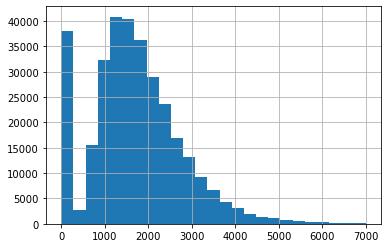

In [149]:
df['sqft'].hist(bins=25)

Заменим очень нулевые значения на среднее.

In [150]:
df.loc[df['sqft'] < 15, 'sqft'] = 1920

df[['baths', 'sqft', 'target']].corr()

,baths,sqft,target
baths,1.000000,0.593330,0.476135
sqft,0.593330,1.000000,0.393259
target,0.476135,0.393259,1.000000


Такой столбец будет довольно проблематично использовать напрямую, поэтому давайте заменим этот столбец на категориальный следующим образом:
- 1 - маленькая площадь (меньше 0,25 квантиля)
- 2 - стандартная (от 0.25 до 0.75)
- 3 - большая (больше 0.75)

In [151]:
df['sqft_type'] = 0
df.loc[df['sqft'] == 0, 'sqft_type'] = 0
df.loc[(df['sqft'] < df['sqft'].quantile(0.25)) & (df['sqft'] != 0), 'sqft_type'] = 1
df.loc[(df['sqft'] > df['sqft'].quantile(0.25)) & (df['sqft'] < df['sqft'].quantile(0.75)), 'sqft_type'] = 2
df.loc[(df['sqft'] > df['sqft'].quantile(0.75)), 'sqft_type'] = 3

In [152]:
df[['baths', 'sqft', 'sqft_type', 'target']].sample(8)

,baths,sqft,sqft_type,target
106358,3.0,1377,2,620000
262884,3.0,1808,2,259000
250611,3.0,2395,3,731856
314811,3.0,2862,3,539000
43227,2.0,1676,2,299900
243564,3.0,1920,2,799000
211904,2.0,1157,1,995000
32670,3.0,2548,3,245000


In [153]:
df[['baths', 'sqft', 'sqft_type', 'target']].corr()

,baths,sqft,sqft_type,target
baths,1.000000,0.593330,0.538191,0.476135
sqft,0.593330,1.000000,0.849988,0.393259
sqft_type,0.538191,0.849988,1.000000,0.346845
target,0.476135,0.393259,0.346845,1.000000


In [154]:
df[['baths', 'sqft', 'sqft_type', 'target']].corr()

,baths,sqft,sqft_type,target
baths,1.000000,0.593330,0.538191,0.476135
sqft,0.593330,1.000000,0.849988,0.393259
sqft_type,0.538191,0.849988,1.000000,0.346845
target,0.476135,0.393259,0.346845,1.000000


Отлично. Корреляция прослеживается. Но давайте оставим и старую фичу на всякий случай. 

## Колонка "zipcode"

Это айдишники. Эту колонку учитывать не будем.

In [155]:
df = df.drop(columns='zipcode')

## Колонка "beds"

In [156]:
show_col_info('beds')
df['beds'].value_counts(dropna=False)

Колонка - beds
Кол-во пропусков: 72316
Кол-во уникальных значений: 736


NaN           72316
3 Beds        48509
4 Beds        30658
3             28671
2 Beds        23456
              ...  
3,354 sqft        1
1.36 acres        1
8.25 acres        1
2.47 acres        1
3,009 sqft        1
Name: beds, Length: 737, dtype: int64

In [157]:
df['beds'] = df['beds'].str.upper()

In [158]:
show_col_info('beds')
df['beds'].value_counts(dropna=False)[:20]

Колонка - beds
Кол-во пропусков: 72316
Кол-во уникальных значений: 736


NaN       72316
3 BEDS    48509
4 BEDS    30658
3         28671
2 BEDS    23456
4         16796
2         14841
BATHS     13430
3 BD      12188
3.0        7939
5 BEDS     7662
4 BD       7566
2 BD       4981
4.0        4915
1          4419
5          4079
2.0        2381
6 BEDS     1983
5 BD       1983
5.0        1097
Name: beds, dtype: int64

In [159]:
def clear_beds(x):
    try:
        if 'SQF' in x or 'ACR' in x:
            return 0
        else:
            number = re.sub(r'[^0-9.,]', r'', x)
            number = int(number.replace(',', '.'))
            return number
            #return int(re.sub(r'\D+', '', x))
    except:
        return 0

In [160]:
pd.Series([clear_beds(x) for x in df['beds']]).value_counts()

0     107576
3      89369
4      55020
2      43278
5      13724
1       5447
6       3205
7        715
8        505
9        204
10       108
12        53
11        38
64        35
14        11
13        10
16         8
18         5
20         2
44         1
15         1
17         1
22         1
24         1
34         1
dtype: int64

In [161]:
pd.Series([clear_beds(x) for x in df['beds']]).describe()

count    319319.000000
mean          2.142037
std           1.872651
min           0.000000
25%           0.000000
50%           3.000000
75%           3.000000
max          64.000000
dtype: float64

In [162]:
df['beds_cleared'] = [clear_beds(x) for x in df['beds']]

In [163]:
df[['sqft', 'beds', 'beds_cleared', 'target']].sample(10)

,sqft,beds,beds_cleared,target
360679,1439,4 BEDS,4,824999
327165,826,3 BEDS,3,83000
289692,1690,4 BEDS,4,179900
287627,992,2,2,499900
191937,810,NaN,0,85000
324668,3123,4 BEDS,4,799000
272335,1550,3 BEDS,3,300000
125589,1352,BATHS,0,194999
175954,1275,3 BEDS,3,355000
279897,554,NaN,0,199000


In [164]:
df.loc[df['beds_cleared'] == 64, ['sqft', 'beds', 'beds_cleared', 'target']]

,sqft,beds,beds_cleared,target
6317,1920,64 BEDS,64,250000
28785,1920,64 BEDS,64,39900
34168,1920,64 BEDS,64,23500
34379,1920,64 BEDS,64,25000
57736,1920,64 BEDS,64,62600
65444,1920,64 BEDS,64,270000
66530,1920,64 BEDS,64,16500
66983,1920,64 BEDS,64,99000
68201,1920,64 BEDS,64,265000
82812,1920,64 BEDS,64,125000


In [165]:
df['beds_cleared'].quantile(0.999)

9.0

In [166]:
(df['beds_cleared'] > 10).value_counts()

False    319151
True        168
Name: beds_cleared, dtype: int64

In [167]:
df = df[df['beds_cleared'] < 10]

<AxesSubplot:>

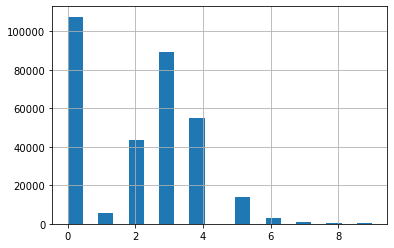

In [168]:
df['beds_cleared'].hist(bins=20)

In [169]:
df.loc[df['beds_cleared'] != 0, 'beds_cleared'].mean()

3.210529302444353

In [170]:
df['beds_cleared_2'] = df['beds_cleared']
df.loc[(df['beds_cleared_2'] == 0) & (df['target'] > df['target'].mean()), 'beds_cleared_2'] = 4
df.loc[(df['beds_cleared_2'] == 0) & (df['target'] < df['target'].mean()), 'beds_cleared_2'] = 3

In [171]:
df[['sqft', 'sqft_type', 'beds_cleared', 'beds_cleared_2', 'target']].corr()

,sqft,sqft_type,beds_cleared,beds_cleared_2,target
sqft,1.000000,0.850744,0.289750,0.551269,0.393048
sqft_type,0.850744,1.000000,0.292109,0.530297,0.346510
beds_cleared,0.289750,0.292109,1.000000,0.394807,0.199145
beds_cleared_2,0.551269,0.530297,0.394807,1.000000,0.317490
target,0.393048,0.346510,0.199145,0.317490,1.000000


Давайте сделаем также, как с площадью.

- 1 - 1 или 2 комнаты
- 2 - 3, 4 команаты
- 3 - 5, 6 комнат
- 4 7 и больше

In [172]:
df['beds_type'] = 1
df.loc[(df['beds_cleared_2'] < 3) & (df['beds_cleared_2'] != 0), 'beds_type'] = 1
df.loc[(df['beds_cleared_2'] > 2) & (df['beds_cleared_2'] < 5), 'beds_type'] = 2
df.loc[(df['beds_cleared_2'] > 4) & (df['beds_cleared_2'] < 7), 'beds_type'] = 3
df.loc[(df['beds_cleared_2'] > 7), 'beds_type'] = 4

In [173]:
df[['sqft', 'sqft_type', 'beds_cleared', 'beds_cleared_2', 'beds_type', 'target']].corr()

,sqft,sqft_type,beds_cleared,beds_cleared_2,beds_type,target
sqft,1.000000,0.850744,0.289750,0.551269,0.445679,0.393048
sqft_type,0.850744,1.000000,0.292109,0.530297,0.444917,0.346510
beds_cleared,0.289750,0.292109,1.000000,0.394807,0.272688,0.199145
beds_cleared_2,0.551269,0.530297,0.394807,1.000000,0.804877,0.317490
beds_type,0.445679,0.444917,0.272688,0.804877,1.000000,0.118977
target,0.393048,0.346510,0.199145,0.317490,0.118977,1.000000


In [174]:
df = df.drop(columns = ['beds_cleared', 'beds'])

## Колонка "state"

In [175]:
show_col_info('state')
df['state'].value_counts(dropna=False)

Колонка - state
Кол-во пропусков: 0
Кол-во уникальных значений: 38


FL    97336
TX    76197
NC    20125
TN    16705
CA    15525
NY    13797
OH    11906
WA    11627
IL     7879
NV     7771
GA     5938
CO     5796
PA     5080
MI     3931
DC     3595
AZ     3297
IN     3083
OR     2511
UT     1175
MA     1025
MD      914
VT      823
MO      789
VA      680
NJ      432
WI      409
ME      249
IA      238
KY       86
OK       43
MS       38
SC       28
MT        7
DE        4
AL        1
OT        1
OS        1
Fl        1
Name: state, dtype: int64

In [176]:
df['state'] = df['state'].astype('category')

## Колонка "stories"

In [177]:
show_col_info('stories')
df['stories'].value_counts(dropna=False)

Колонка - stories
Кол-во пропусков: 119832
Кол-во уникальных значений: 309


NaN                       119832
1.0                        62636
2.0                        47659
1                          21619
2                          15283
                           ...  
Split Entry (Bi-Level)         1
3 Story, Multi Level           1
Craftsman                      1
32                             1
None                           1
Name: stories, Length: 310, dtype: int64

In [178]:
df['stories'] = df['stories'].str.upper()

In [179]:
def clear_stories(x):
    try:
        if isinstance(x, int) or isinstance(x, float):
            x = str(x)
        if 'ONE' in x:
            return 1
        if 'TWO' in x or 'TOWNHOUSE' in x:
            return 2
        if 'THREE' in x:
            return 3
        
        else:
            number = re.sub(r'[^0-9.,]', r'', x)
            if number[-1] == ',':
                number = number[:-1]
            number = float(number.replace(',', '.'))
            return int(np.ceil(number))
    except:
        return 0

In [180]:
df['stories'] = [clear_stories(x) for x in df['stories']]

In [181]:
df.loc[df['stories'] > df['stories'].quantile(0.95), 'stories'] = df['stories'].quantile(0.95)

## Колонки "mls-id" и "MlsId"

Это айдишники, которые ничего не несут. Их просто дропнем.

In [182]:
df = df.drop(columns=['mls-id', 'MlsId'])

# Результат

In [188]:
df.sample(8)

,status,propertyType,street,baths,fireplace,city,sqft,state,stories,PrivatePool,target,has_adress,built_year,was_remodeled,remodel_year,house_age,last_remodeled,heating,cooling,parking,n_schools,min_dist_school,mean_dist_school,min_rating_school,max_rating_school,mean_rating_school,sqft_type,beds_cleared_2,beds_type
25753,ACTIVE,NO DATA,CIRCLE,2.0,0,MIAMI,1000,FL,0.0,0.0,284990,1,1986,1,1986,36,35,AIR,OTHER,NONE,5,0.50,5.720000,3.0,10.0,7.250000,1,3,2
93482,FOR SALE,SINGLE,COURT,2.0,0,LANCASTER,1920,CA,0.0,0.0,324900,1,1990,0,0,32,-1,OTHER,CENTRAL,NONE,3,0.30,0.833333,1.0,3.0,1.666667,2,4,2
75463,ACTIVE,FLAT,DRIVE,3.0,0,KEY BISCAYNE,1335,FL,0.0,0.0,495000,1,1970,1,1970,52,51,AIR,OTHER,NONE,5,0.70,7.420000,5.0,10.0,7.250000,2,4,2
323730,FOR SALE,SINGLE,COURT,3.0,1,FORT WORTH,3200,TX,1.0,0.0,449000,1,1951,1,1965,71,56,AIR,CENTRAL,OTHER,3,1.08,1.613333,2.0,6.0,4.000000,3,3,2
340367,NO_DATA,SINGLE,STREET,3.0,1,PLANTATION,2843,FL,2.0,1.0,799000,1,1978,1,1979,44,42,OTHER,CENTRAL,TWO,3,1.30,3.366667,3.0,8.0,5.000000,3,4,2
13608,NO_DATA,TOWNHOUSE,DRIVE,3.0,0,AVENTURA,2290,FL,0.0,0.0,699000,1,1983,1,1983,39,38,AIR,CENTRAL,TWO,2,1.60,2.300000,5.0,7.0,6.000000,3,3,2
99462,FOR SALE,LAND,OTHER,2.0,0,HOUSTON,1920,TX,0.0,0.0,119900,1,1985,0,0,37,-1,NO_DATA,NO_DATA,NONE,3,1.58,3.506667,2.0,3.0,2.333333,2,3,2
23811,ACTIVE,SINGLE,DRIVE,3.0,1,WOODSTOCK,3485,IL,2.0,0.0,399900,1,1990,0,0,32,-1,NO_DATA,CENTRAL,OTHER,8,1.40,2.437500,4.0,9.0,6.400000,3,4,2


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319043 entries, 0 to 377184
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   status              319043 non-null  object  
 1   propertyType        319043 non-null  object  
 2   street              319043 non-null  object  
 3   baths               319043 non-null  float64 
 4   fireplace           319043 non-null  int64   
 5   city                319043 non-null  object  
 6   sqft                319043 non-null  int64   
 7   state               319043 non-null  category
 8   stories             319043 non-null  float64 
 9   PrivatePool         319043 non-null  float64 
 10  target              319043 non-null  int64   
 11  has_adress          319043 non-null  int64   
 12  built_year          319043 non-null  int64   
 13  was_remodeled       319043 non-null  int64   
 14  remodel_year        319043 non-null  int64   
 15  house_age        

Отлично. Все данные почищены. Пропусков нет.

В некоторых столбцах пропуски были заменены на "No Data". Поймем, как с ними быть в ходе построения моделей.

Что было сделано:
- Все переменные отчистили от мусора и привели в вид, в котором будем передавать в модель
- Создали много новых фичей
- Отбросили сильные выбросы, которые бы "путали" модель.

Сохраним данные и построим модели в отдельном ноутбуке.

In [192]:
df.to_csv('df_cleared.csv', index=False)